In [1]:
%env QXToken=5cd4fb14ed1e310399096fe9bd62d528d5999de11ad231bf5e0ca742f7a4e3dd0960a5ddcde760edfbda609b5411e036f45965998ec4993e6336d7b2ed414701
%env QC_GRADING_ENDPOINT=https://qac-grading.quantum-computing.ibm.com
%env QXAuthURL=https://auth.quantum-computing.ibm.com/api


env: QXToken=5cd4fb14ed1e310399096fe9bd62d528d5999de11ad231bf5e0ca742f7a4e3dd0960a5ddcde760edfbda609b5411e036f45965998ec4993e6336d7b2ed414701
env: QC_GRADING_ENDPOINT=https://qac-grading.quantum-computing.ibm.com
env: QXAuthURL=https://auth.quantum-computing.ibm.com/api


In [2]:
import os
# verify enviroment setting
print((os.environ['QXToken'],
os.environ['QC_GRADING_ENDPOINT'],
os.environ['QXAuthURL']))

('5cd4fb14ed1e310399096fe9bd62d528d5999de11ad231bf5e0ca742f7a4e3dd0960a5ddcde760edfbda609b5411e036f45965998ec4993e6336d7b2ed414701', 'https://qac-grading.quantum-computing.ibm.com', 'https://auth.quantum-computing.ibm.com/api')


In [4]:
!pip install --upgrade git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git --user
!pip install qiskit[all]

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to c:\users\sun\appdata\local\temp\pip-req-build-xkjr_296


  Running command git clone -q https://github.com/qiskit-community/Quantum-Challenge-Grader.git 'C:\Users\sun\AppData\Local\Temp\pip-req-build-xkjr_296'


  Using cached qiskit_optimization-0.1.0-py3-none-any.whl (115 kB)
  Attempting uninstall: qiskit-optimization
    Found existing installation: qiskit-optimization 0.2.3
    Uninstalling qiskit-optimization-0.2.3:
      Successfully uninstalled qiskit-optimization-0.2.3
  Attempting uninstall: qiskit-nature
    Found existing installation: qiskit-nature 0.2.2
    Uninstalling qiskit-nature-0.2.2:
      Successfully uninstalled qiskit-nature-0.2.2
  Attempting uninstall: qiskit-machine-learning
    Found existing installation: qiskit-machine-learning 0.2.1
    Uninstalling qiskit-machine-learning-0.2.1:
      Successfully uninstalled qiskit-machine-learning-0.2.1
  Attempting uninstall: qiskit-finance
    Found existing installation: qiskit-finance 0.2.1
    Uninstalling qiskit-finance-0.2.1:
      Successfully uninstalled qiskit-finance-0.2.1


In [3]:
from typing import List, Union
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble
from qiskit.compiler import transpile
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit.library import QFT

In [4]:
instance_examples = [
    {
        'L1': [3, 7, 3, 4, 2, 6, 2, 2, 4, 6, 6],
        'L2': [7, 8, 7, 6, 6, 9, 6, 7, 6, 7, 7],
        'C1': [2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2],
        'C2': [4, 3, 3, 4, 4, 5, 3, 4, 4, 3, 4],
        'C_max': 33
    },
    {
        'L1': [4, 2, 2, 3, 5, 3, 6, 3, 8, 3, 2],
        'L2': [6, 5, 8, 5, 6, 6, 9, 7, 9, 5, 8],
        'C1': [3, 3, 2, 3, 4, 2, 2, 3, 4, 2, 2],
        'C2': [4, 4, 3, 5, 5, 3, 4, 5, 5, 3, 5],
        'C_max': 38
    },
    {
        'L1': [5, 4, 3, 3, 3, 7, 6, 4, 3, 5, 3],
        'L2': [9, 7, 5, 5, 7, 8, 8, 7, 5, 7, 9],
        'C1': [2, 2, 4, 2, 3, 4, 2, 2, 2, 2, 2],
        'C2': [3, 4, 5, 4, 4, 5, 3, 3, 5, 3, 5],
        'C_max': 35
    }
]

In [56]:
def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)
    
    ##############################
    # U_1(gamma * (lambda2 - lambda1)) for each qubit
    for i in range(index_qubits):
        qc.rz(-0.78*gamma*(L2[i]-L1[i]), qr_index[i])
    # qc.decompose.draw()
    ##############################
    
    return qc.to_gate(label=" phase return ") if to_gate else qc

In [55]:
def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(data_qubits)
    ##############################
    ### Phase Rotation ###
    m = 0
    pre = 1
    if const < 0:
        const = -const
        pre = -1

    const_b = format(const, f'0{data_qubits}b')
    const_b = const_b[::-1]
    # print(f'const_b: {const_b}')    
    # solution 1
    if const:
        for i in range(data_qubits): # i is 0, 1,..,n-1
            for j in range(i+1): # j in [0],..,[0,..,data_qubits-1]
                if int(const_b[j]): # b='00 000 000 01{0}'
                    m += 1/2**(i-j)
            if (math.pi*m)%(2*math.pi) !=0:
                qc.p(pre*(math.pi*m)%(2*math.pi), i)
                m=0
            #print(f'i: {i}, j in: {data_qubits-i}, m: {m}, const_b: {const_b[data_qubits-j-1]}')
    # solution 2
    # for j in range(data_qubits):
    #     for k in range(data_qubits - j):
    #         lam = math.pi / (2 ** k)
    #         if int(const_b[j]):
    #             qc.p(lam, j+k)
    # print(qc)

    ##############################
    return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc


In [57]:
def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_data)
    
    ##############################
    ### QFT ###
    qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])

    ### Phase Rotation ###
    # Use `subroutine_add_const`
    qc.append(subroutine_add_const(data_qubits=data_qubits, const=const), qr_data[:])

    ### IQFT ###
    qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])

    ##############################
    return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc

In [51]:
# penalty part
def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_index, qr_data)

    for i, (val1, val2) in enumerate(zip(list1, list2)):
        
        ##############################
        ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
        # Provide your code here
        qc.append(const_adder(data_qubits=data_qubits, const=val2).control(), [qr_index[i]] + qr_data[:])

        qc.x(qr_index[i]) # flip control qubit
        
        ##############################
        ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
        # Provide your code here
        qc.append(const_adder(data_qubits=data_qubits, const=val1).control(), [qr_index[i]] + qr_data[:])

        qc.x(qr_index[i]) # flip control qubit

    return qc.to_gate(label=" Cost Calculation ") if to_gate else qc

In [11]:
# penalty part
def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_index, qr_data)

    qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])

    for i, (val1, val2) in enumerate(zip(list1, list2)):

        ##############################
        ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
        # Provide your code here
        const = val2
        m = 0
        pre = 1
        if const < 0:
            const = -const
            pre = -1

        const_b = format(const, f'0{data_qubits}b')
        const_b = const_b[::-1]
        # print(f'const_b: {const_b}')    
        # solution 1
        if const:
            for k in range(data_qubits): # i is 0, 1,..,n-1
                for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                    if int(const_b[j]): # b='00 000 000 01{0}'
                        m += 1/2**(k-j)
                if (math.pi*m)%(2*math.pi) !=0:
                    qc.cp(pre*(math.pi*m)%(2*math.pi), qr_index[i], qr_data[k])
                    m=0
        #qc.append(const_adder(data_qubits=data_qubits, const=val2).control(), [qr_index[i]] + qr_data[:])
        #qc.append(const_adder(data_qubits=data_qubits, const=val2).control(), [qr_index[index_qubits-i-1]] + qr_data[:])

        qc.x(qr_index[i]) # flip control qubit

        ##############################
        ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
        # Provide your code here
        const = val1
        if const < 0:
            const = -const
            pre = -1

        const_b = format(const, f'0{data_qubits}b')
        const_b = const_b[::-1]
        # print(f'const_b: {const_b}')    
        # solution 1
        if const:
            for k in range(data_qubits): # i is 0, 1,..,n-1
                for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                    if int(const_b[j]): # b='00 000 000 01{0}'
                        m += 1/2**(k-j)
                if (math.pi*m)%(2*math.pi) !=0:
                    qc.cp(pre*(math.pi*m)%(2*math.pi), qr_index[i], qr_data[k])
                    m=0
        # qc.append(const_adder(data_qubits=data_qubits, const=val1).control(), [qr_index[index_qubits-i-1]] + qr_data[:])

        qc.x(qr_index[i]) # flip control qubit
    
    qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])

    return qc.to_gate(label=" Cost Calculation ") if to_gate else qc

In [12]:
def constraint_testing(data_qubits: int, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)
    
    ##############################
    ### Set the flag register for indices with costs larger than C_max ###
    # Provide your code here
    # c_max_b = format(C_max, f'0{data_qubits}b') # binary formulation of C_max
    # if C_max <= 2**(data_qubits) - 1: # sum of cost can exceed the c_max
    #     # searching '0' in binary formulation of C_max
    #     fst_one_index = 0
    #     for i, b in enumerate(c_max_b):
    #         if int(b) == 1:
    #             fst_one_index = data_qubits - i - 1
    #             break
    #     zero_indexs = [i for i, b in enumerate(c_max_b) if int(b) == 0]
    #     print(f'zeros: {zero_indexs}, fst_one_index: {fst_one_index}')
    #     ctrl_gates = []
    #     addr_gates = []
        
    #     if zero_indexs:
    #         for zero_i in zero_indexs:
    #             end_index = zero_indexs.pop()
    #             num_ctrl_qubits = fst_one_index - end_index + 1 # num_qubits = fst_one_index - end_index + 1
    #             sub_cir = QuantumCircuit(num_ctrl_qubits + 1)
    #             ctrl_gates.append(sub_cir.x(0).to_gate().control(num_ctrl_qubits = num_ctrl_qubits)]
    #             addr_gates.append([fst_one_index, end_index])
    #         qc_ctrls = QuantumRegister(len(ctrl_gates), "ctrl_gates")
    qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])
    c = (C_max).bit_length()
    gap = 2**c - C_max
    const = gap
    m = 0
    pre = 1
    if const < 0:
        const = -const
        pre = -1

    const_b = format(const, f'0{data_qubits}b')
    const_b = const_b[::-1]
    # print(f'const_b: {const_b}')    
    # solution 1
    if const:
        for k in range(data_qubits): # i is 0, 1,..,n-1
            for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                if int(const_b[j]): # b='00 000 000 01{0}'
                    m += 1/2**(k-j)
            if (math.pi*m)%(2*math.pi) !=0:
                qc.p(pre*(math.pi*m)%(2*math.pi), qr_data[k])
                m=0
    qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])
    sub_cir = QuantumCircuit(1)
    sub_cir.x(0)
    qc.append(sub_cir.to_gate().control(num_ctrl_qubits=data_qubits-c, ctrl_state=0), qr_data[c:] + [qr_f[0]])

    qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])

    const = -gap
    m = 0
    pre = 1
    if const < 0:
        const = -const
        pre = -1

    const_b = format(const, f'0{data_qubits}b')
    const_b = const_b[::-1]
    # print(f'const_b: {const_b}')    
    # solution 1
    if const:
        for k in range(data_qubits): # i is 0, 1,..,n-1
            for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                if int(const_b[j]): # b='00 000 000 01{0}'
                    m += 1/2**(k-j)
            if (math.pi*m)%(2*math.pi) !=0:
                qc.p(pre*(math.pi*m)%(2*math.pi), qr_data[k])
                m=0
    qc.x(qr_f[0])
    qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])
    ##############################
    
    return qc.to_gate(label=" Constraint Testing ") if to_gate else qc

In [13]:
# penalty part
def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate = True) -> Union[Gate, QuantumCircuit]:

    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)
    # c = (C_max).bit_length()

    ##############################
    ### Phase Rotation ###

    for i in range(data_qubits):
        qc.cp(1.02*2**i*alpha*gamma, qr_f[0], i)
    qc.p(-1.02*C_max*alpha*gamma, qr_f[0])
    # qc.p(C_max*alpha*gamma, qr_f[0])

    ##############################

    return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc
    
def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_index, qr_data, qr_f)
    
    ##############################
    ### Reinitialization Circuit ###
    
    qc.append(constraint_testing(data_qubits=data_qubits, C_max=C_max).inverse(), qr_data[:] + qr_f[:])
    qc.append(cost_calculation(index_qubits=index_qubits, data_qubits=data_qubits, list1=C1, list2=C2).inverse(), qr_index[:] + qr_data[:])
    
    # to_gate = False
    # qc.reset(qr_data[:])
    # qc.reset(qr_f[:])
    
    ##############################
    
    return qc.to_gate(label=" Reinitialization ") if to_gate else qc

In [22]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
example = instance_examples[0]
c1 = example['C1']
c2 = example['C2']
C_max = example['C_max']

# L1 = [5,3,3,6,9,7,1]
# L2 = [8,4,5,12,10,11,2]
# c1 = [1,1,2,1,1,1,2]
# c2 = [3,2,3,2,4,3,3]
# C_max = 8

p = 5
alpha = 1
i = 0
beta = 1 - (i + 1) / p
gamma = (i + 1) / p
#C_Max = 10
data_qubits = len(example['L1'])
index_qubits = len(example['L1'])

index_reg = QuantumRegister(index_qubits, "indexRegister")
data_reg = QuantumRegister(data_qubits, "dataRegister")
flag_reg = QuantumRegister(1, "flagRegister")
c_bits = ClassicalRegister(data_qubits , "classicalRegister")
c_max_flag = ClassicalRegister(1, "cmaxflag")

qc = QuantumCircuit(index_reg, data_reg, flag_reg, c_bits, c_max_flag)
# test 1: index reg = 00..00 => take value only from L1 and C1
# test 2:  ..       = 11..11 => take value only from L2 and C2
# test 3: with qc.h without qc.x to test reinitilization
# qc.x(index_reg[:])
qc.h(index_reg[:])
# total cost
qc.append(cost_calculation(index_qubits=index_qubits, data_qubits=data_qubits, list1=c1, list2=c2), index_reg[:]+data_reg[:])
# flag
qc.append(constraint_testing(data_qubits=data_qubits, C_max= C_max), data_reg[:]+flag_reg[:])


qc.append(penalty_dephasing(data_qubits=data_qubits, alpha=alpha, gamma=gamma), data_reg[:]+flag_reg[:])
qc.append(reinitialization(index_qubits=index_qubits,data_qubits=data_qubits,C1=c1,C2=c2, C_max=C_max), index_reg[:] + data_reg[:] + flag_reg[:])

qc.measure(data_reg[:], c_bits[:])
qc.measure(flag_reg[:], c_max_flag[:])
print(f'circuit: {qc}')

circuit:                       ┌───┐┌──────────────────────┐                          »
     indexRegister_0: ┤ X ├┤0                     ├──────────────────────────»
                      ├───┤│                      │                          »
     indexRegister_1: ┤ X ├┤1                     ├──────────────────────────»
                      ├───┤│                      │                          »
     indexRegister_2: ┤ X ├┤2                     ├──────────────────────────»
                      ├───┤│                      │                          »
     indexRegister_3: ┤ X ├┤3                     ├──────────────────────────»
                      ├───┤│                      │                          »
     indexRegister_4: ┤ X ├┤4                     ├──────────────────────────»
                      ├───┤│                      │                          »
     indexRegister_5: ┤ X ├┤5                     ├──────────────────────────»
                      ├───┤│               

{'0 00000000000': 1000}


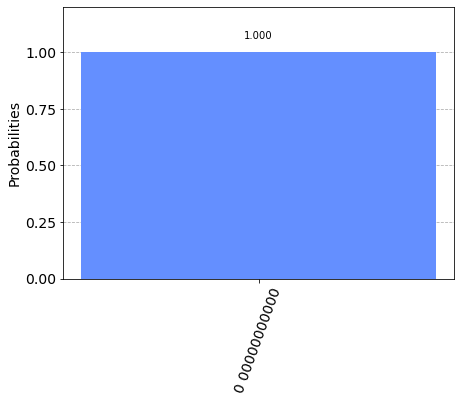

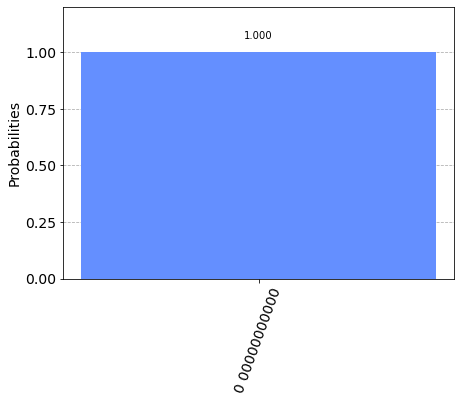

In [23]:
# test run
sim = Aer.get_backend("aer_simulator")
trans_adder = transpile(qc, sim)
result = sim.run(trans_adder, shots=1000).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

In [91]:
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    
    # the number of qubits representing answers
    index_qubits = len(L1)
    
    # the maximum possible total cost
    max_c = sum([max(l0, l1) for l0, l1 in zip(C1, C2)])
    
    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
    data_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2
    
    ### Phase Operator ###
    # return part
    ws=[0.78,1.02,-1.02]
    #ws = [0.2*0.78*math.pi, 0.2*1.02*math.pi, -1.02*0.2*math.pi]
    def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
        ##############################
        #param = np.array([l1-l2 for l1, l2 in zip(L1, L2)]).std()
        qr_index = QuantumRegister(index_qubits, "index")
        qc = QuantumCircuit(qr_index)
        param = 0
        for i in range(index_qubits):
            qc.p(-ws[0]*(1-param)*gamma*(L2[i]-L1[i]), qr_index[i])
            # qc.p(gamma*(L2[i]-L1[i]), qr_index[index_qubits-1-i])
            # qc.barrier()
        # qc.decompose.draw()

        ##############################
        
        return qc.to_gate(label=" phase return ") if to_gate else qc
    
    # penalty part
    def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        qc = QuantumCircuit(data_qubits)
        ##############################
        ### Phase Rotation ###
        m = 0
        pre = 1
        if const < 0:
            const = -const
            pre = -1

        const_b = format(const, f'0{data_qubits}b')
        const_b = const_b[::-1]
        # print(f'const_b: {const_b}')    
        # solution 1
        if const:
            for i in range(data_qubits): # i is 0, 1,..,n-1
                for j in range(i+1): # j in [0],..,[0,..,data_qubits-1]
                    if int(const_b[j]): # b='00 000 000 01{0}'
                        m += 1/2**(i-j)
                if (math.pi*m)%(2*math.pi) !=0:
                    qc.p(pre*(math.pi*m)%(2*math.pi), i)
                    m=0
                    #print(f'i: {i}, j in: {data_qubits-i}, m: {m}, const_b: {const_b[data_qubits-j-1]}')
        # solution 2
        # for j in range(data_qubits):
        #     for k in range(data_qubits - j):
        #         lam = pre*math.pi / (2 ** k)
        #         if int(const_b[j]):
        #             qc.p(lam, j+k)
        # print(qc)

        ##############################
        return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc

    # penalty part
    def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qc = QuantumCircuit(qr_data)

        ##############################
        ### QFT ###
        qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])

        ### Phase Rotation ###
        # Use `subroutine_add_const`
        qc.append(subroutine_add_const(data_qubits=data_qubits, const=const), qr_data[:])

        ### IQFT ###
        qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])

        ##############################
        return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc 
    
    # penalty part
    def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:
        qr_index = QuantumRegister(index_qubits, "index")
        qr_data = QuantumRegister(data_qubits, "data")
        qc = QuantumCircuit(qr_index, qr_data)

        for i, (val1, val2) in enumerate(zip(list1, list2)):

            ##############################
            ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
            # Provide your code here
            qc.append(const_adder(data_qubits=data_qubits, const=val2).control(), [qr_index[i]] + qr_data[:])
            #qc.append(const_adder(data_qubits=data_qubits, const=val2).control(), [qr_index[index_qubits-i-1]] + qr_data[:])

            qc.x(qr_index[i]) # flip control qubit

            ##############################
            ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
            # Provide your code here
            qc.append(const_adder(data_qubits=data_qubits, const=val1).control(), [qr_index[i]] + qr_data[:])
            # qc.append(const_adder(data_qubits=data_qubits, const=val1).control(), [qr_index[index_qubits-i-1]] + qr_data[:])

            qc.x(qr_index[i]) # flip control qubit

        return qc.to_gate(label=" Cost Calculation ") if to_gate else qc
    
    # penalty part
    def constraint_testing(data_qubits: int, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_data, qr_f)

        ##############################
        ### Set the flag register for indices with costs larger than C_max ###
        c = (C_max).bit_length()
        #   1101
        # c = 4
        # 0{0}1101 
        gap = 2**c - C_max
        qc.append(const_adder(data_qubits=data_qubits, const=gap), qr_data[:])
        sub_cir = QuantumCircuit(1)
        sub_cir.x(0)
        qc.append(sub_cir.to_gate().control(num_ctrl_qubits=data_qubits-c, ctrl_state=0), qr_data[c:] + [qr_f[0]])
        
        qc.append(const_adder(data_qubits=data_qubits, const=-gap), qr_data[:]) # minus the gap
        qc.x(qr_f[0])
        ##############################

        return qc.to_gate(label=" Constraint Testing ") if to_gate else qc
    
    # penalty part
    def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_data, qr_f)
        #param = np.array([l1-l2 for l1, l2 in zip(L1, L2)]).std()
        # c = (C_max).bit_length()

        ##############################
        ### Phase Rotation ###
        param = 0
        for i in range(data_qubits):
            qc.cp(ws[1]*(1-param)*(2**i)*alpha*gamma, qr_f[0], i)
        #qc.p(ws[2]*(0.2+param)*C_max*alpha*gamma, qr_f[0])
        qc.p(ws[2]*C_max*alpha*gamma, qr_f[0])
        # qc.p(C_max*alpha*gamma, qr_f[0])

        ##############################

        return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc
        
    def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
        
        qr_index = QuantumRegister(index_qubits, "index")
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_index, qr_data, qr_f)
        
        ##############################
        ### Reinitialization Circuit ###
        
        qc.append(constraint_testing(data_qubits=data_qubits, C_max=C_max).inverse(), qr_data[:] + qr_f[:])
        qc.append(cost_calculation(index_qubits=index_qubits, data_qubits=data_qubits, list1=C1, list2=C2).inverse(), qr_index[:] + qr_data[:])
        
        # to_gate = False
        # qc.reset(qr_data[:])
        # qc.reset(qr_f[:])
        
        ##############################
        
        return qc.to_gate(label=" Reinitialization ") if to_gate else qc

    ### Mixing Operator ###
    def mixing_operator(index_qubits: int, beta: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
        
        qr_index = QuantumRegister(index_qubits, "index")
        qc = QuantumCircuit(qr_index)
        
        ##############################
        ### Mixing Operator ###
        
        for i in range(index_qubits):
            qc.rx(2*beta, qr_index[i])
        
        
        ##############################
        
        return qc.to_gate(label=" Mixing Operator ") if to_gate else qc

        
    qr_index = QuantumRegister(index_qubits, "index") # index register
    qr_data = QuantumRegister(data_qubits, "data") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_index = ClassicalRegister(index_qubits, "c_index") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_index, qr_data, qr_f, cr_index)
    
    ### initialize the index register with uniform superposition state ###
    qc.h(qr_index)
    
    ### DO NOT CHANGE THE CODE BELOW
    p = 5
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(index_qubits, gamma, L1, L2), qr_index)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(index_qubits, data_qubits, C1, C2), qr_index[:] + qr_data[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(data_qubits, C_max), qr_data[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(data_qubits, alpha, gamma), qr_data[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), qr_index[:] + qr_data[:] + qr_f[:])
        
        ### mixing operator ###
        qc.append(mixing_operator(index_qubits, beta), qr_index)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_index, cr_index[::-1])
    
    return qc

In [110]:
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    
    # the number of qubits representing answers
    index_qubits = len(L1)
    
    # the maximum possible total cost
    max_c = sum([max(l0, l1) for l0, l1 in zip(C1, C2)])
    
    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
    data_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2
    
    ### Phase Operator ###
    # return part
    ws = [0.2*0.78*math.pi, 0.2*1.02*math.pi, -0.2*1.02*math.pi]
    def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
        ##############################
        
        qr_index = QuantumRegister(index_qubits, "index")
        qc = QuantumCircuit(qr_index)
        for i in range(index_qubits):
            qc.p(-ws[0]*gamma*(L2[i]-L1[i]), qr_index[i])
        # qc.decompose.draw()

        ##############################
        
        return qc.to_gate(label=" phase return ") if to_gate else qc
    
    # penalty part
    def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        qc = QuantumCircuit(data_qubits)
        ##############################
        ### Phase Rotation ###

        ##############################
        return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc

    # penalty part
    def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qc = QuantumCircuit(qr_data)

        ##############################
        ### QFT ###
        ##############################
        return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc 
    
    def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:
        qr_index = QuantumRegister(index_qubits, "index")
        qr_data = QuantumRegister(data_qubits, "data")
        qc = QuantumCircuit(qr_index, qr_data)

        qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])

        for i, (val1, val2) in enumerate(zip(list1, list2)):

            ##############################
            ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
            # Provide your code here
            if val1 != val2:
                const = val2
                m = 0
                pre = 1
                if const < 0:
                    const = -const
                    pre = -1

                const_b = format(const, f'0{data_qubits}b')
                const_b = const_b[::-1]
                # print(f'const_b: {const_b}')    
                # solution 1
                if const:
                    for k in range(data_qubits): # i is 0, 1,..,n-1
                        for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                            if int(const_b[j]): # b='00 000 000 01{0}'
                                m += 1/2**(k-j)
                        if (math.pi*m)%(2*math.pi) !=0:
                            qc.cp(pre*(math.pi*m)%(2*math.pi), qr_index[i], qr_data[k])
                            m=0

                qc.x(qr_index[i]) # flip control qubit

                ##############################
                ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
                # Provide your code here
                const = val1
                if const < 0:
                    const = -const
                    pre = -1

                const_b = format(const, f'0{data_qubits}b')
                const_b = const_b[::-1]
                # print(f'const_b: {const_b}')    
                # solution 1
                if const:
                    for k in range(data_qubits): # i is 0, 1,..,n-1
                        for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                            if int(const_b[j]): # b='00 000 000 01{0}'
                                m += 1/2**(k-j)
                        if (math.pi*m)%(2*math.pi) !=0:
                            qc.cp(pre*(math.pi*m)%(2*math.pi), qr_index[i], qr_data[k])
                            m=0

                qc.x(qr_index[i]) # flip control qubit
            else:
                const = val2
                m = 0
                pre = 1
                if const < 0:
                    const = -const
                    pre = -1

                const_b = format(const, f'0{data_qubits}b')
                const_b = const_b[::-1]
                # print(f'const_b: {const_b}')    
                # solution 1
                if const:
                    for k in range(data_qubits): # i is 0, 1,..,n-1
                        for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                            if int(const_b[j]): # b='00 000 000 01{0}'
                                m += 1/2**(k-j)
                        if (math.pi*m)%(2*math.pi) !=0:
                            qc.p(pre*(math.pi*m)%(2*math.pi), qr_data[k])
                            m=0

        # qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])
        qc=transpile(qc, seed_transpiler=42, optimization_level=2)
        return qc.to_gate(label=" Cost Calculation ") if to_gate else qc
    
    # constraint_testing
    def constraint_testing(data_qubits: int, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_data, qr_f)

        ##############################
        ### Set the flag register for indices with costs larger than C_max ###
        
        # qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])
        
        c = (C_max).bit_length()
        gap = 2**c - C_max
        const = gap
        m = 0
        pre = 1
        if const < 0:
            const = -const
            pre = -1

        const_b = format(const, f'0{data_qubits}b')
        const_b = const_b[::-1]
        # print(f'const_b: {const_b}')    
        # solution 1
        if const:
            for k in range(data_qubits): # i is 0, 1,..,n-1
                for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                    if int(const_b[j]): # b='00 000 000 01{0}'
                        m += 1/2**(k-j)
                if (math.pi*m)%(2*math.pi) !=0:
                    qc.p(pre*(math.pi*m)%(2*math.pi), qr_data[k])
                    m=0
        #qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])
        sub_cir = QuantumCircuit(1)
        sub_cir.x(0)
        qc.append(sub_cir.to_gate().control(num_ctrl_qubits=data_qubits-c, ctrl_state=0), qr_data[c:] + [qr_f[0]])

        #qc.append(QFT(num_qubits=data_qubits, do_swaps=False).to_gate(), qr_data[:])

        const = -gap
        m = 0
        pre = 1
        if const < 0:
            const = -const
            pre = -1

        const_b = format(const, f'0{data_qubits}b')
        const_b = const_b[::-1]
        # print(f'const_b: {const_b}')    
        # solution 1
        if const:
            for k in range(data_qubits): # i is 0, 1,..,n-1
                for j in range(k+1): # j in [0],..,[0,..,data_qubits-1]
                    if int(const_b[j]): # b='00 000 000 01{0}'
                        m += 1/2**(k-j)
                if (math.pi*m)%(2*math.pi) !=0:
                    qc.p(pre*(math.pi*m)%(2*math.pi), qr_data[k])
                    m=0
        qc.x(qr_f[0])
        #qc.append(QFT(num_qubits=data_qubits, inverse=True, do_swaps=False).to_gate(), qr_data[:])
        ##############################

        return qc.to_gate(label=" Constraint Testing ") if to_gate else qc

    # penalty part
    def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_data, qr_f)
        # c = (C_max).bit_length()

        ##############################
        ### Phase Rotation ###
        for i in range(data_qubits):
            qc.cp(ws[1]*(2**i)*alpha*gamma, qr_f[0], i)
        qc.p(ws[2]*C_max*alpha*gamma, qr_f[0])

        ##############################

        return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc
        
    def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
        
        qr_index = QuantumRegister(index_qubits, "index")
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_index, qr_data, qr_f)
        
        ##############################
        ### Reinitialization Circuit ###
        
        qc.append(constraint_testing(data_qubits=data_qubits, C_max=C_max).inverse(), qr_data[:] + qr_f[:])
        qc.append(cost_calculation(index_qubits=index_qubits, data_qubits=data_qubits, list1=C1, list2=C2).inverse(), qr_index[:] + qr_data[:])
        
        ##############################
        
        return qc.to_gate(label=" Reinitialization ") if to_gate else qc

    ### Mixing Operator ###
    def mixing_operator(index_qubits: int, beta: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
        
        qr_index = QuantumRegister(index_qubits, "index")
        qc = QuantumCircuit(qr_index)
        
        ##############################
        ### Mixing Operator ###
        
        for i in range(index_qubits):
            qc.rx(2*beta, qr_index[i])
        
        
        ##############################
        
        return qc.to_gate(label=" Mixing Operator ") if to_gate else qc

        
    qr_index = QuantumRegister(index_qubits, "index") # index register
    qr_data = QuantumRegister(data_qubits, "data") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_index = ClassicalRegister(index_qubits, "c_index") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_index, qr_data, qr_f, cr_index)
    
    ### initialize the index register with uniform superposition state ###
    qc.h(qr_index)
    
    ### DO NOT CHANGE THE CODE BELOW
    p = 5
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(index_qubits, gamma, L1, L2), qr_index)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(index_qubits, data_qubits, C1, C2), qr_index[:] + qr_data[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(data_qubits, C_max), qr_data[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(data_qubits, alpha, gamma), qr_data[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), qr_index[:] + qr_data[:] + qr_f[:])
        
        ### mixing operator ###
        qc.append(mixing_operator(index_qubits, beta), qr_index)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_index, cr_index[::-1])
    
    return qc

In [111]:
from qc_grader import prepare_ex4c
job = prepare_ex4c(solver_function)
result = job.result()

Running "solver_function" (1/8)... 
Running "solver_function" (2/8)... 
Running "solver_function" (3/8)... 
Running "solver_function" (4/8)... 
Running "solver_function" (5/8)... 
Running "solver_function" (6/8)... 
Running "solver_function" (7/8)... 
Running "solver_function" (8/8)... 
Starting experiments. Please wait...
You may monitor the job (id: 61854e30ce94111eee6be965) status and proceed to grading when it successfully completes.


In [112]:
import qc_grader
qc_grader.__version__
from qc_grader.grade import grade_job
grade_job(job, '4c')
#  grade_ex4c(job)

Grading your answer for 4c. Please wait...

Oops 😕! The average precision for the 4 fixed data set is lower than the threshold 0.8. Please try again.
Please review your answer and try again.


(False, None)

In [109]:
from qc_grader import grade_ex4c
grade_ex4c(job)

Submitting your answer for 4c. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 1023424.


In [92]:
for j in range(3):
    locals().update(instance_examples[j])
    L_opts = [67, 62, 66]
    L_opt = L_opts[j]
    qc = solver_function(L1=L1, L2=L2, C1=C1, C2=C2, C_max=C_max)

    sim = Aer.get_backend("aer_simulator")
    trans_adder = transpile(qc, sim)
    result = sim.run(trans_adder, shots=512).result()
    counts = result.get_counts()
    # print(counts)
    # plot_histogram(counts, figsize=(15,5))

    def calculator(bitstr):
        C=0
        L=0
        for j,i in enumerate(bitstr):
            if i=='0':
                C+=C1[j]
                L+=L1[j]
            else:
                C+=C2[j]
                L+=L2[j]
        # print(L, C)
        return L, C

    def score():
        L_min = sum([min(l0, l1) for l0, l1 in zip(L1, L2)])
        N_f = 0
        S = 0
        for c in counts.items():
            L, C = calculator(c[0])
            if C <= C_max:
                S += (L-L_min)*c[1]
                N_f += c[1]
        
        S /= N_f*(L_opt-L_min)
        print(S)
        return S
    score()

0.8451178451178452
0.8003663003663004
0.9638888888888889


In [6]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
import numpy as np
from qiskit_optimization.applications import Knapsack


In [9]:
instance_examples = [
    {
        'L1': [3, 7, 3, 4, 2, 6, 2, 2, 4, 6, 6],
        'L2': [7, 8, 7, 6, 6, 9, 6, 7, 6, 7, 7],
        'C1': [2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2],
        'C2': [4, 3, 3, 4, 4, 5, 3, 4, 4, 3, 4],
        'C_max': 33
    },
    {
        'L1': [4, 2, 2, 3, 5, 3, 6, 3, 8, 3, 2],
        'L2': [6, 5, 8, 5, 6, 6, 9, 7, 9, 5, 8],
        'C1': [3, 3, 2, 3, 4, 2, 2, 3, 4, 2, 2],
        'C2': [4, 4, 3, 5, 5, 3, 4, 5, 5, 3, 5],
        'C_max': 38
    },
    {
        'L1': [5, 4, 3, 3, 3, 7, 6, 4, 3, 5, 3],
        'L2': [9, 7, 5, 5, 7, 8, 8, 7, 5, 7, 9],
        'C1': [2, 2, 4, 2, 3, 4, 2, 2, 2, 2, 2],
        'C2': [3, 4, 5, 4, 4, 5, 3, 3, 5, 3, 5],
        'C_max': 35
    }
]

In [35]:
from qiskit.aqua.components.optimizers import COBYLA
sc = 0
for j in range(3):
    def object_function(w:list):
        locals().update(instance_examples[j])
        L_opts = [67, 62, 66]
        L_opt = L_opts[j]
        qc = solver_function(L1=L1, L2=L2, C1=C1, C2=C2, C_max=C_max, ws=w)

        sim = Aer.get_backend("aer_simulator")
        trans_adder = transpile(qc, sim)
        result = sim.run(trans_adder, shots=512).result()
        counts = result.get_counts()
        # print(counts)
        # plot_histogram(counts, figsize=(15,5))

        def calculator(bitstr):
            C=0
            L=0
            for j,i in enumerate(bitstr):
                if i=='0':
                    C+=C1[j]
                    L+=L1[j]
                else:
                    C+=C2[j]
                    L+=L2[j]
            # print(L, C)
            return L, C

        def score():
            L_min = sum([min(l0, l1) for l0, l1 in zip(L1, L2)])
            N_f = 0
            S = 0
            for c in counts.items():
                L, C = calculator(c[0])
                if C <= C_max:
                    S += (L-L_min)*c[1]
                    N_f += c[1]
            
            S /= N_f*(L_opt-L_min)*(-1)# COBYLA is minimize optimizer
            sc = S
            print(S)
            return S
        return score()

    ws= ([0.8, 3, -2],[],[]) # [0.78, 1.02, -1.02]
    for tol in [0.01, 0.001, 0.00001]:
        optimizer = COBYLA(maxiter=1, tol=tol)
        ws = optimizer.optimize(num_vars=3, objective_function=object_function, initial_point=ws[0])
        print(f'score: {sc}, weights with step {tol} for return: {ws[0][0]}, cost: {ws[0][1]}, cmax: {ws[0][2]}')


-0.7916146050256837
score: 0, weights with step 0.01 for return: 0.8, cost: 3.0, cmax: -2.0
-0.8021768707482994
score: 0, weights with step 0.001 for return: 0.8, cost: 3.0, cmax: -2.0
-0.7953033268101761
score: 0, weights with step 1e-05 for return: 0.8, cost: 3.0, cmax: -2.0


KeyboardInterrupt: 

In [8]:
import qc_grader
qc_grader.__version__

'0.8.7'

In [7]:
from qiskit import IBMQ
IBMQ.save_account('5cd4fb14ed1e310399096fe9bd62d528d5999de11ad231bf5e0ca742f7a4e3dd0960a5ddcde760edfbda609b5411e036f45965998ec4993e6336d7b2ed414701')
IBMQ.load_account()
IBMQ.providers()

configrc.store_credentials:WARNING:2021-11-05 10:59:05,738: Credentials already present. Set overwrite=True to overwrite.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='iqc-fall-21-1', group='challenge-2', project='rech3qVe7pj1PiIoe')>]

In [9]:
from qc_grader import prepare_ex4c
job = prepare_ex4c(solver_function)

result = job.result()

Running "solver_function" (1/8)... 
Running "solver_function" (2/8)... 
Running "solver_function" (3/8)... 
Running "solver_function" (4/8)... 
Running "solver_function" (5/8)... 
Running "solver_function" (6/8)... 
Running "solver_function" (7/8)... 
Running "solver_function" (8/8)... 
Starting experiments. Please wait...
You may monitor the job (id: 61850826ee4ec478d986a0fd) status and proceed to grading when it successfully completes.


In [67]:
# Check your answer and submit using the following code
import qc_grader
qc_grader.__version__
from qc_grader.grade import grade_job
grade_job(job, '4c')
#  grade_ex4c(job)

Grading your answer for 4c. Please wait...
Failed: Gateway Time-out


(False, None)

In [33]:
from qc_grader import grade_ex4c
grade_ex4c(job)

Submitting your answer for 4c. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 1468824.
